In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import random
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv('Iris.csv')
print(df1.head())


   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa


In [3]:
def getInfoDF(df):
    print(df.info(), '\n')
    print(df.isnull().sum(), '\n')
    print(df.shape)

getInfoDF(df1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
None 

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64 

(150, 6)


In [4]:
df1['Species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [5]:
df1['Species'] = df1['Species'].map({'Iris-setosa':0,'Iris-versicolor':1, 'Iris-virginica':2 })

In [6]:

df1.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,0
1,2,4.9,3.0,1.4,0.2,0
2,3,4.7,3.2,1.3,0.2,0
3,4,4.6,3.1,1.5,0.2,0
4,5,5.0,3.6,1.4,0.2,0


# Removing [ Id ] with pd.df.drop()

In [7]:
df1.drop(['Id'], axis=1, inplace=True)

In [8]:
df1.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [9]:
X = df1.drop(['Species'], axis=1).values #inputs
y = df1['Species'].values #labels

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


## StandardScaler:
  + is a preprocessing technique in scikit-learn used for standardizing features by **removing the mean and scaling to unit variance**.


## Normalization Process:
   + StandardScaler operates on the **principle of normalization**, 
   
   + where it transforms the **distribution of each feature** to have a **mean of zero** and a **standard deviation of one**. 
   
   + This process ensures that all features are on the same scale,**preventing any single feature from dominating the learning process due to its larger magnitude**.

In [11]:
scaler = StandardScaler()

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.30, random_state=42)

### transform:
  + used to perform **scaling using mean and std** calculated using the .fit() method.


### fit_transform:
   +  method does both fits and transform.

In [15]:
xTrain = scaler.fit_transform(xTrain)
xTest = scaler.transform(xTest)

#### Converting From Numpy Array To Torch Tensor

In [22]:
xTrain = torch.FloatTensor(xTrain)
xTest = torch.FloatTensor(xTest)
yTrain = torch.LongTensor(yTrain)
yTest = torch.LongTensor(yTest)

print(xTrain.shape)
print(xTest.shape)
print(yTrain.shape)
print(yTest.shape)

torch.Size([105, 4])
torch.Size([45, 4])
torch.Size([105])
torch.Size([45])


# Model

In [23]:
class ClasifyNN(nn.Module):
    def __init__(self, inputDim, outputDim):
        super(ClasifyNN, self).__init__()
        self.inputLayer = nn.Linear(inputDim, 128)
        self.hiddnLayer = nn.Linear(128, 64)
        self.outputLayer = nn.Linear(64, outputDim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.relu(self.inputLayer(x))
        out = self.relu(self.hiddnLayer(out))
        out = self.relu(self.outputLayer(out))
        
        return out


In [24]:
# input_dim = 4 because we have 4 inputs namely sepal_length,sepal_width,petal_length,petal_width
# output_dim = 3 because we have namely 3 categories setosa,versicolor and virginica

inputDim = 4
outputDim = 3

model = ClasifyNN(inputDim, outputDim)
print(model)


ClasifyNN(
  (inputLayer): Linear(in_features=4, out_features=128, bias=True)
  (hiddnLayer): Linear(in_features=128, out_features=64, bias=True)
  (outputLayer): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
)


In [25]:
lr = 0.01
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=lr)


/home/dkcode/miniconda3/envs/tfenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Train

In [31]:
maxSteps = 1000
trainLoss = np.zeros(maxSteps)
testLoss = np.zeros(maxSteps)

for i in range(maxSteps):
   
    optim.zero_grad()

    # forward pass
    logits = model(xTrain)

    #loss
    loss = criterion(logits, yTrain)
    loss.backward()

    #update the weights
    optim.step()

    outputTst = model(xTest)
    lossTest = criterion(outputTst, yTest)

    trainLoss[i] = loss.item()
    testLoss[i] = loss.item()

    if i % 100 == 0:
        print(f"Epoch {i}/{maxSteps}, Train Loss: {loss.item():.4f}, Test Loss: {lossTest.item():.4f}")
    
print('Done Train')

Epoch 0/1000, Train Loss: 0.3977, Test Loss: 0.3174
Epoch 100/1000, Train Loss: 0.3985, Test Loss: 0.3179
Epoch 200/1000, Train Loss: 0.3979, Test Loss: 0.3179
Epoch 300/1000, Train Loss: 0.3978, Test Loss: 0.3177
Epoch 400/1000, Train Loss: 0.3976, Test Loss: 0.3191
Epoch 500/1000, Train Loss: 0.4112, Test Loss: 0.3200
Epoch 600/1000, Train Loss: 0.3977, Test Loss: 0.3174
Epoch 700/1000, Train Loss: 0.0549, Test Loss: 0.0203
Epoch 800/1000, Train Loss: 0.0333, Test Loss: 0.0139
Epoch 900/1000, Train Loss: 0.0189, Test Loss: 0.0019
Done Train


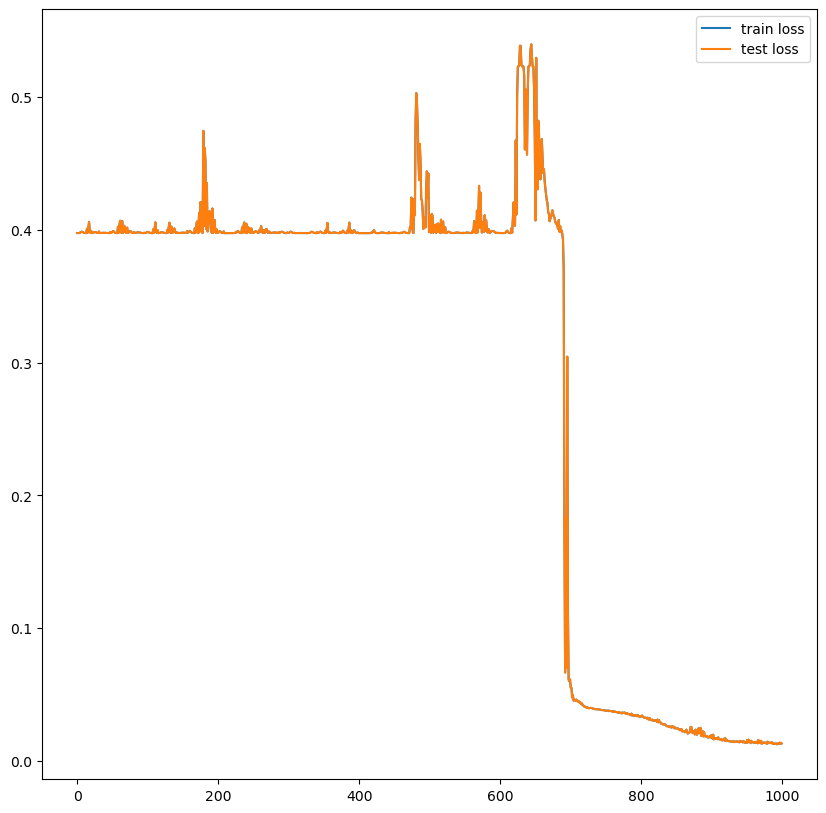

In [33]:

plt.figure(figsize=(10,10))
plt.plot(testLoss, label='train loss')
plt.plot(testLoss, label='test loss')
plt.legend()
plt.show()

In [34]:
prdictTrain = []
predictTst = []

with torch.no_grad():
    prdictTrain = model(xTrain)
    predictTst = model(xTest)
    

In [41]:
# Check how the predicted outputs look like and after taking argmax compare with y_train or y_test 
#predictions_train  
#y_train,y_test

def getAccMultiClass(predictArr, orignilArr):
    if len(predictArr) != len(orignilArr):
        return False
    
    predictArr = predictArr.numpy()
    orignilArr = orignilArr.numpy()
    finalPredict = []

    for i in range(len(predictArr)):
        finalPredict.append(np.argmax(predictArr[i]))
    finalPredict = np.array(finalPredict)
    count = 0
    for i in range(len(orignilArr)):
        if finalPredict[i] == orignilArr[i]:
            count += 1
    return count/len(finalPredict)

In [45]:
trainAcc = getAccMultiClass(prdictTrain, yTrain)
testAcc = getAccMultiClass(predictTst, yTest)

In [47]:
print(f'training acc: {round(trainAcc*100, 3)}')
print(f'test acc: {round(testAcc*100, 3)}')

training acc: 99.048
test acc: 100.0
